# Imports

In [1]:
# Dynamic
%matplotlib notebook
# Standard
# %matplotlib inline

from os.path import join, isdir, basename
from glob import iglob
import sys
import json
import pickle
import pandas
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import draw_learning_curve

# Allow to import the modules in the model folder
sys.path.append('../model/')

fig_width = 16 # full screen: 16 / half screen: 10
fig_height = 8

# path of the folder with the results
res_path = '../model/res/'

# Functions

In [2]:
def split_seeds_and_sims(cluster_sim_path, param_filter=[]):
    """
    - cluster_sim_path:  name of the folder with all the results
    - param_filter: list of filters. Each filter contains the accepted values
    for one type of parameter in the name of the sub-folder in cluster_sim_path
    """
    run_paths = sorted([run_path for run_path in iglob(join(cluster_sim_path, '*')) if isdir(run_path)])
    options_list = []
    seeds = set()
    sims = set()
    
    for path in run_paths:
        # seperate seeds values and option configuration in the file name
        options = basename(path).split("+", 1)
        for i, option in enumerate(options):
            if i == 0:
                seeds.add(option)
            else:
                is_ok = True
                for filters in param_filter:
                    find_one = False
                    for f in filters:
                        if f in option:
                            find_one = True
                            break
                    if not find_one:
                        is_ok = False
                        break
                if is_ok:
                    sims.add(option)

    seeds = sorted(list(seeds))
    sims = natsorted(list(sims))
    print("seeds =", seeds)
    print("sims =", sims)
    print("number of simulations:", len(sims))
    print("number of seeds per simulation:", len(seeds))
    
    return seeds, sims

In [3]:
def extract_data(cluster_sim_path, seeds, sims, nb_days):
    label_names = []  # labels for the legend of the plot
    final_scores = []
    min_scores = np.zeros((len(sims), nb_days*2))  # nb_days*2: day morning + day evening
    """1 line = 1 parameter set ; 1 column = mean over all the seeds
    of the number of gestures for the best song of this day """
    nb_gest = np.zeros((len(sims), nb_days))
    
    for i, sim in enumerate(sims):
        sim_min_score = None
        # for each day, store the number of gestures of the best song
        sim_nb_gest = np.zeros(nb_days)
        
        for seed in seeds:
            sim_name = '+'.join([seed, sim])
            path = cluster_sim_path + sim_name
            
            try:
                with open(join(path, 'data.pkl'), 'rb') as f:
                    songlog = pickle.load(f)
            except FileNotFoundError:
                print(FileNotFoundError)
                continue
                
            root_data = [item[1] for item in songlog if item[0] == 'root']
            rd = pandas.DataFrame(root_data)
            # score_array shape: 1 x nb_days*2
            score_array = []
            for i_day in range(nb_days*2):
                score_array.append(np.amin(rd['scores'].iloc[i_day]))
                """at day evening, after the night which has changed the number of gestures
                and the day which has optimised and gives a best song"""
                if i_day % 2 == 1:
                    i_best = np.argmin(rd['scores'].iloc[i_day])
                    # accumulate the number of gestures of the best song
                    sim_nb_gest[i_day//2] += len(rd['songs'].iloc[i_day][i_best].gestures)
            score_array = np.array([score_array])

            # -- Store the min values of each seed --
            if sim_min_score is None:
                sim_min_score = score_array
            else:
                sim_min_score = np.vstack((sim_min_score, score_array))

        # sim_min_score shape before: nb_seeds x nb_days*2
        # sim_min_score shape after: 1 x nb_days*2
        sim_min_score = np.mean(sim_min_score, axis=0)
        # mutliply by -1 to get a rising curve
        sim_min_score *= -1
        # store the scores
        min_scores[i] = sim_min_score        
        # store the mean final score
        final_scores.append(round(sim_min_score[-1], 3))
        # compute the mean from the sum accumulated
        sim_nb_gest /= len(seeds)
        nb_gest[i] = sim_nb_gest.astype(int)
        """
        /!\ hard fix for specific simulations:
        shorten the name for the legend in the plot
        """
        if "dev_test" in sim:
            sim = sim.split("+")[0]
        if "nlm_div_th_test" in sim:
            sim = sim.split("+")[2]
        if "grid_div_th" in sim:
            sim = sim.split("+")[1]
        elif "dlm_nlm_equilibrium" in sim:
            sim = " ".join(sim.split("+")[3:])
        # store the name of the simulation
        label_names.append(sim)
        
    return min_scores, np.array(final_scores), nb_gest, label_names

In [4]:
def plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps, title=None):
    """Plot the mean learning curve of one parameter set"""
    fig = plt.figure(figsize=(fig_width, fig_height))
    ax = fig.gca()
    for i in range(1, nb_steps, 2):
        ax.axvspan(i, i+1, facecolor='darkblue', alpha=0.1)
    plt.plot(min_scores.T)
    plt.xticks(range(0, nb_steps+1, 2), range(0, nb_steps//2+1))
    plt.xlim(0, nb_steps)
    y_min = -20
    y_max = -5
    plt.ylim(y_min, y_max)
    plt.yticks(range(y_min, y_max+1))
    plt.xlabel('Day')
    plt.ylabel('Error distance from tutor')
    final_title = 'Learning curve'
    if title is not None:
        final_title += ' ({})'.format(title)
    plt.title(final_title)
    legends = ["{} ({})".format(label_names[i], final_scores[i]) for i in range(len(label_names))]
    plt.legend(legends)
#     plt.legend(legends, fontsize="small")
    fig.tight_layout()
    plt.show()

In [5]:
def plot_mean_number_gestures(nb_gest, label_names, nb_days, title=None):
    """Plot for the mean number of gesture in a song per day"""
    x = np.tile(np.arange(1,nb_days+1), (len(nb_gest), 1))
    fig = plt.figure(figsize=(fig_width, fig_height))
    plt.plot(x.T, nb_gest.T, marker='o')
    y_max = 110
    plt.yticks(range(0,y_max+10,10))
    plt.ylim(0, y_max)
    plt.xlabel("Days")
    plt.ylabel("Mean number of gestures")
    plt.grid()
    legends = ["{} (end: {})".format(label_names[i], nb_gest[i][nb_days-1]) for i in range(len(label_names))]
    plt.legend(legends)
#     plt.legend(legends, fontsize="small")
    final_title = "Mean number of gestures in the learned songs per day of learning"
    if title is not None:
        final_title += " ({})".format(title)
    plt.title(final_title)
    fig.tight_layout()
    plt.show()

In [6]:
def plot_corr_nb_gest_score(nb_gest, final_scores, label_names, title=None):
    """Correlation between number of gestures and final score"""
    fig = plt.figure(figsize=(fig_width, fig_height))
    for i in range(len(nb_gest)):
        plt.scatter(nb_gest[i][-1], final_scores[i])
    plt.grid()
    plt.xlabel("Mean number of gestures in the final songs")
    plt.ylabel("Mean scores of the final songs")
    plt.legend(label_names)
    final_title = "Relation between the number of gestures and the final score"
    if title is not None:
        final_title += " ({})".format(title)
    plt.title(final_title)
    fig.tight_layout()
    plt.show()

# Comparison long_div_th_new_params_180917_115103 and no_night_new_params_180917_115152
- These simulations use the new model / params:
    - only  3 mutations
	- initial night population: 3 day songs + 17 mutations
	- max beta value: -0.002
	- last version of prior and dev values

seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['10_split+no_night_new_params+200_train_per_day', '10_split+no_night_new_params+400_train_per_day', '80_split+no_night_new_params+200_train_per_day', '80_split+no_night_new_params+400_train_per_day']
number of simulations: 4
number of seeds per simulation: 10
seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['long_div_th_new_params+3000_diversity_th', 'long_div_th_new_params+3500_diversity_th', 'long_div_th_new_params+4000_diversity_th', 'long_div_th_new_params+4500_diversity_th', 'long_div_th_new_params+5000_diversity_th', 'long_div_th_new_params+6000_diversity_th']
number of simulations: 6
number of seeds per simulation: 10


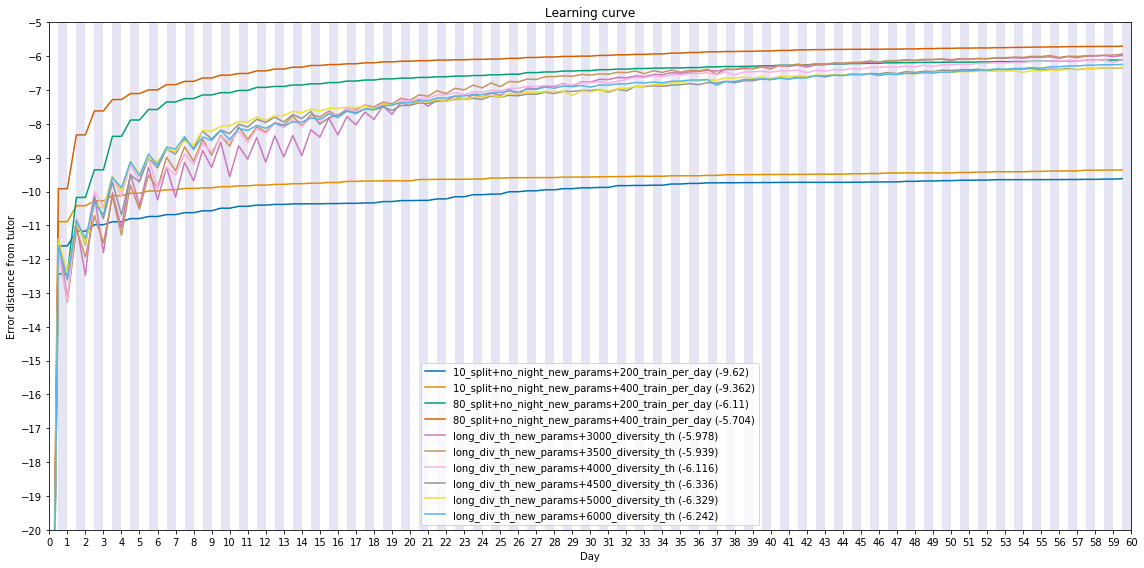

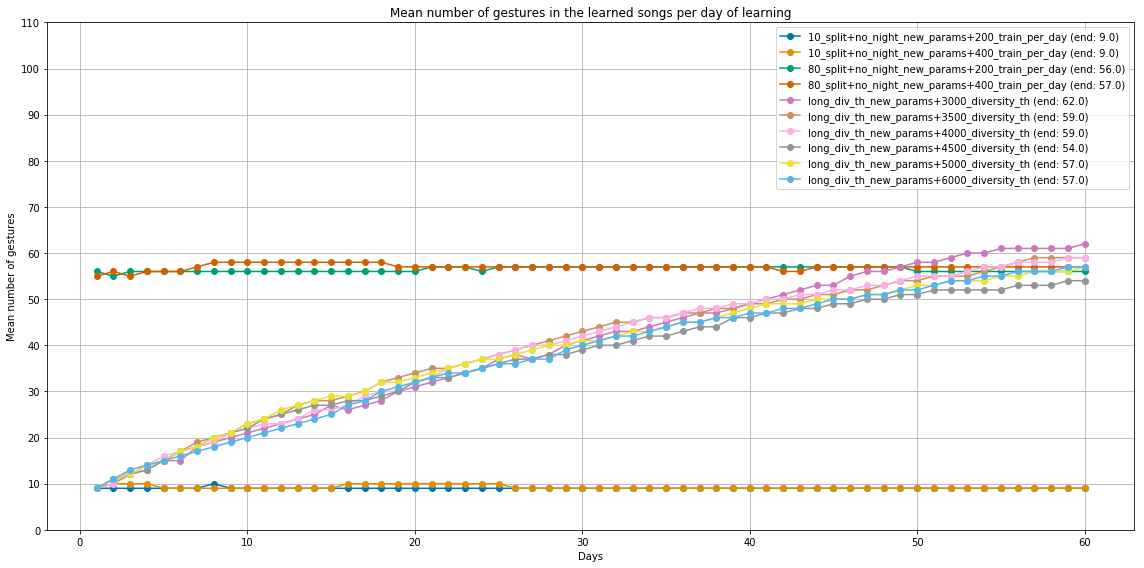

In [10]:
cluster_sim_path = res_path + "no_night_new_params_180917_115152/"
param_filter = []
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
mean_scores_no_night, final_scores_no_night, mean_nb_gest_no_night, label_names_no_night = tup

cluster_sim_path = res_path + 'long_div_th_new_params_180917_115103/'
l_div_th = ['3000', '3500', '4000', '4500', '5000', '6000']
param_filter = [l_div_th]
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
mean_scores_div_th, final_scores_div_th, mean_nb_gest_div_th, label_names_div_th = tup

mean_scores = np.concatenate((mean_scores_no_night, mean_scores_div_th))
final_scores = np.concatenate((final_scores_no_night, final_scores_div_th))
mean_nb_gest = np.concatenate((mean_nb_gest_no_night, mean_nb_gest_div_th))
label_names = label_names_no_night + label_names_div_th
plot_mean_learning_curve(mean_scores, final_scores, label_names, nb_steps)
plot_mean_number_gestures(mean_nb_gest, label_names, run_param['days'])

# no_night_180910_165800

seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['10_split+no_night+200_train_per_day', '10_split+no_night+400_train_per_day', '80_split+no_night+200_train_per_day', '80_split+no_night+400_train_per_day']
number of simulations: 4
number of seeds per simulation: 10


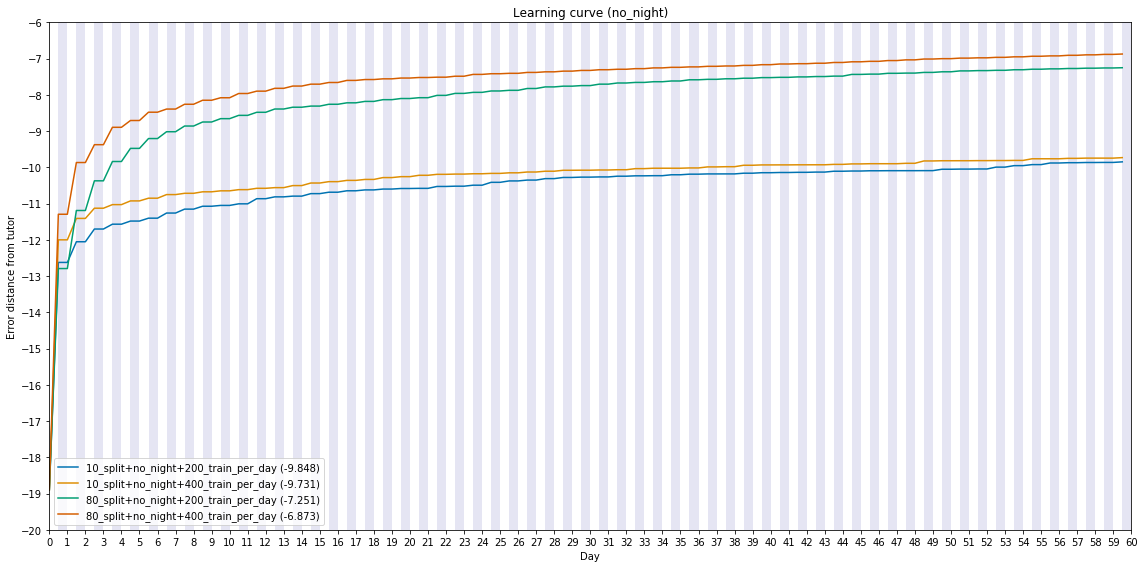

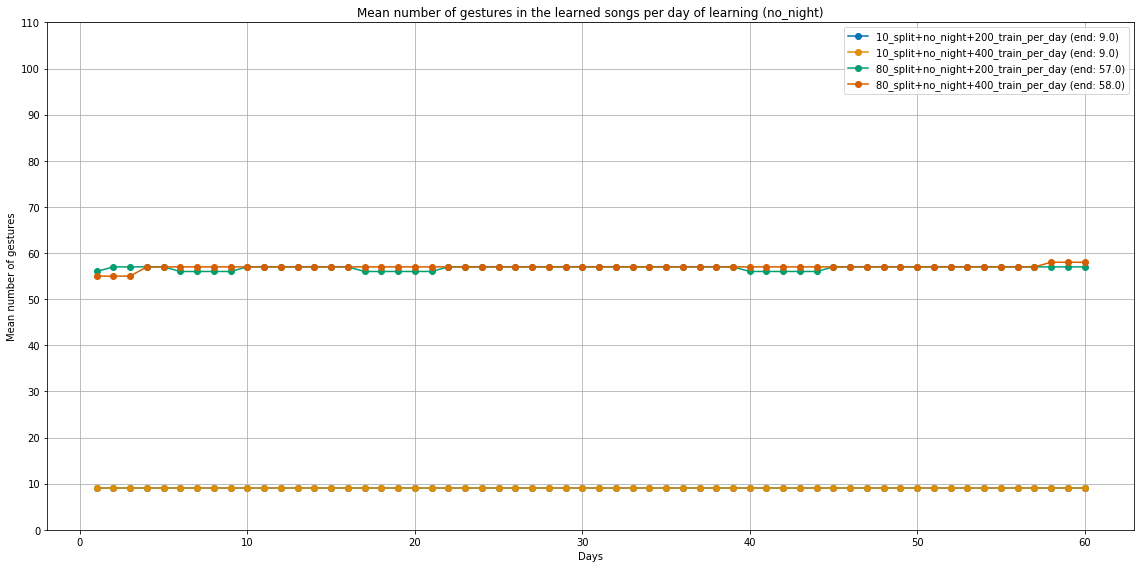

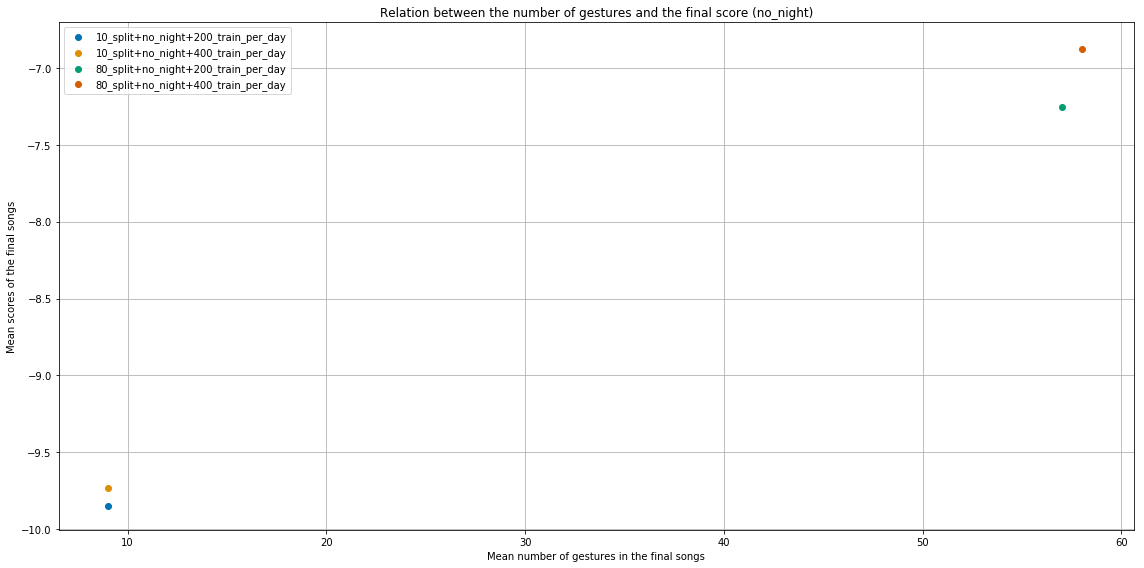

In [14]:
cluster_sim_path = res_path + "no_night_180910_165800/"
param_filter = []
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
min_scores, final_scores, nb_gest, label_names = tup
title = "no_night"
plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps, title)
plot_mean_number_gestures(nb_gest, label_names, run_param['days'], title)
plot_corr_nb_gest_score(nb_gest, final_scores, label_names, title)

# nlm_diversity_7_sim

seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['nlm_diversity_7_sim']
number of simulations: 1
number of seeds per simulation: 10


<IPython.core.display.Javascript object>


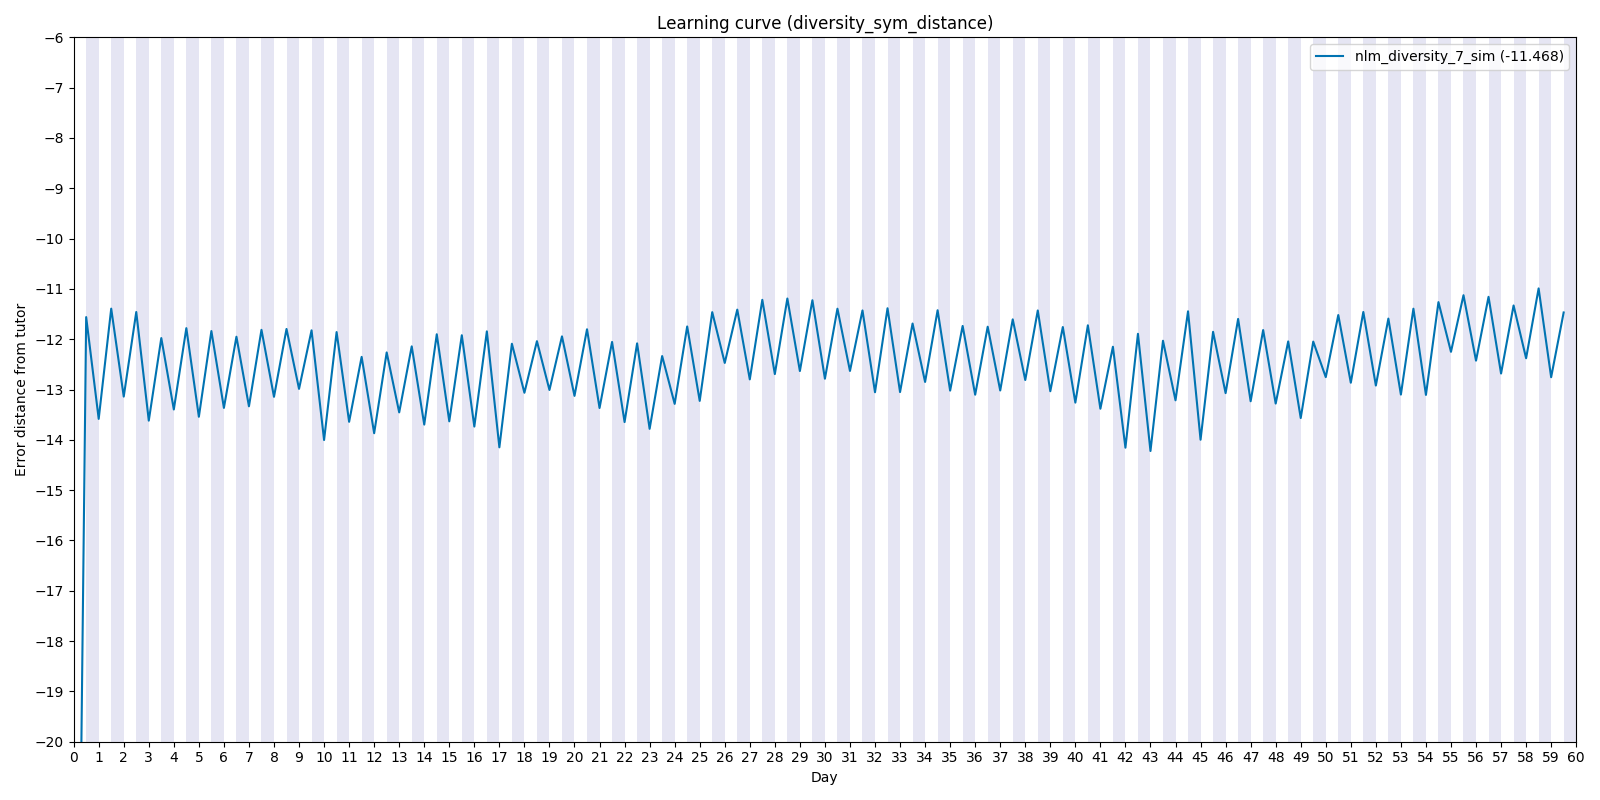

<IPython.core.display.Javascript object>


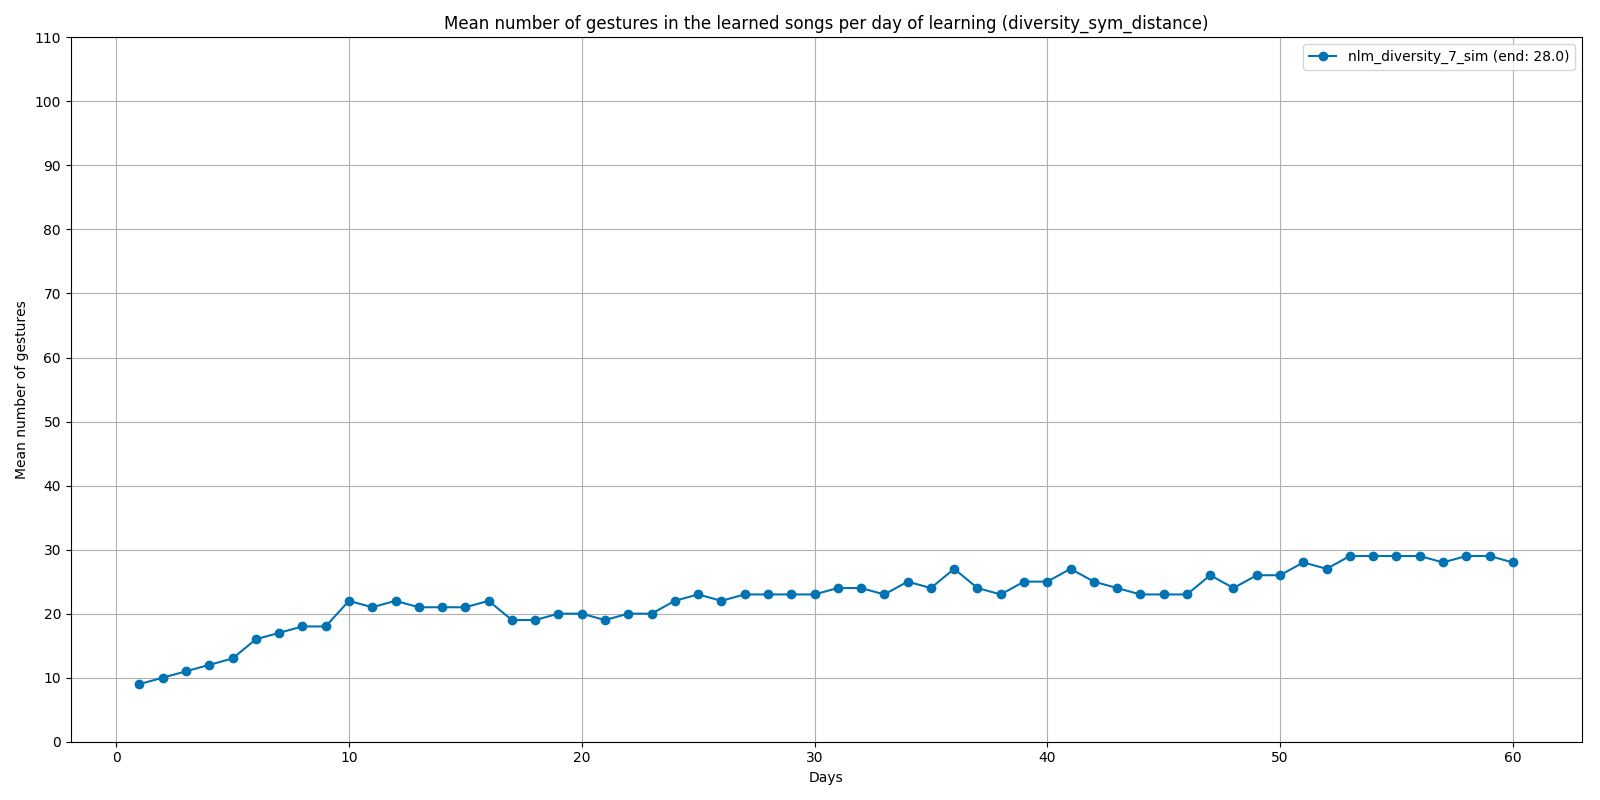

<IPython.core.display.Javascript object>


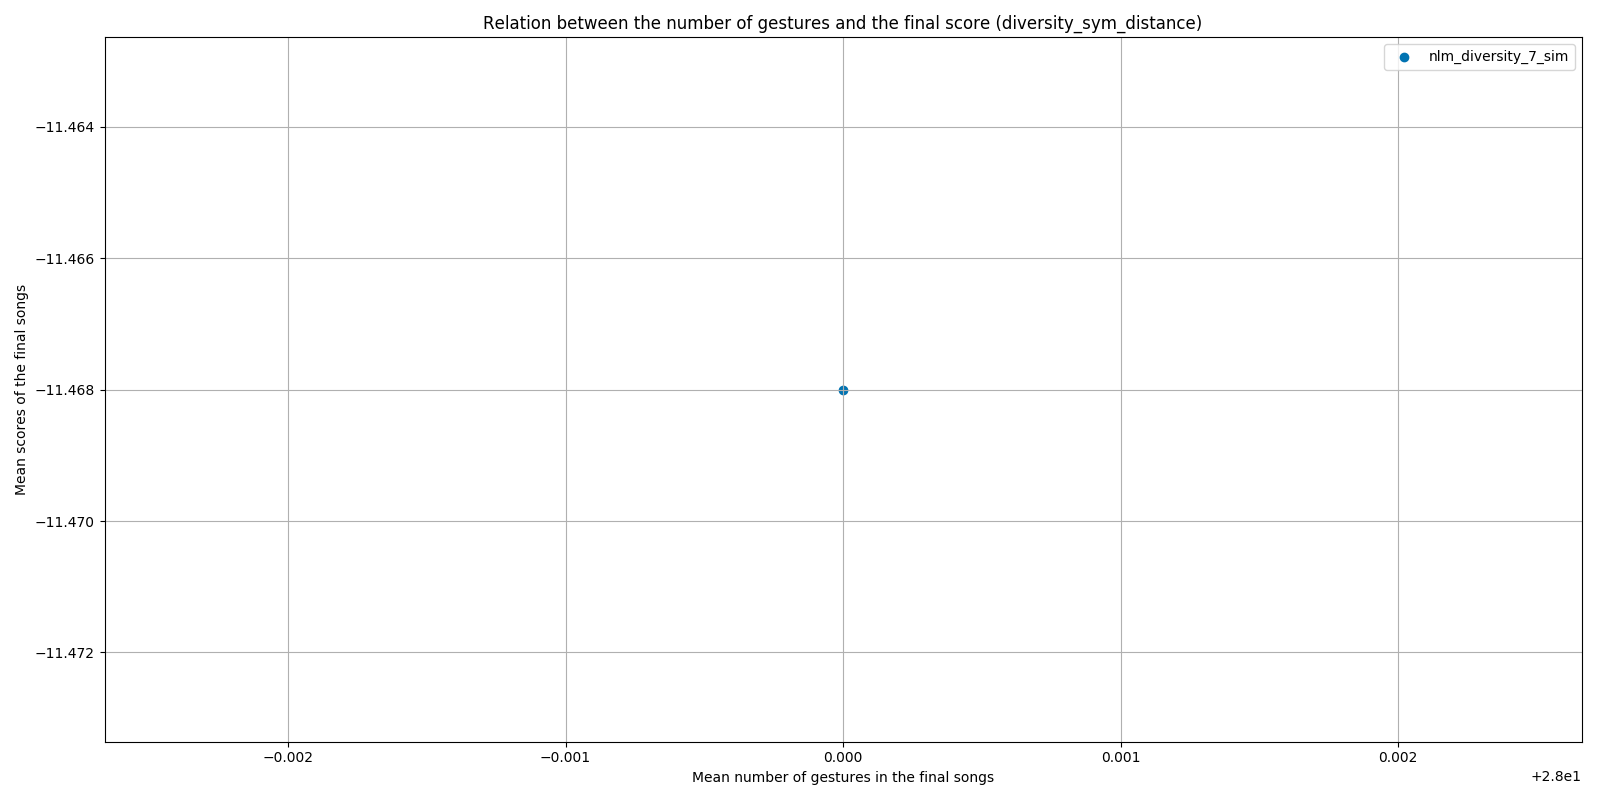

In [8]:
cluster_sim_path = res_path + 'nlm_diversity_7_sim_180907_184124/'
param_filter = []
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
min_scores, final_scores, nb_gest, label_names = tup
title = "diversity_sym_distance"
plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps, title)
plot_mean_number_gestures(nb_gest, label_names, run_param['days'], title)
plot_corr_nb_gest_score(nb_gest, final_scores, label_names, title)

# nlm_diversity_12

seeds = ['seed0', 'seed1', 'seed2']
sims = ['nlm_diversity_12']
number of simulations: 1
number of seeds per simulation: 3


<IPython.core.display.Javascript object>


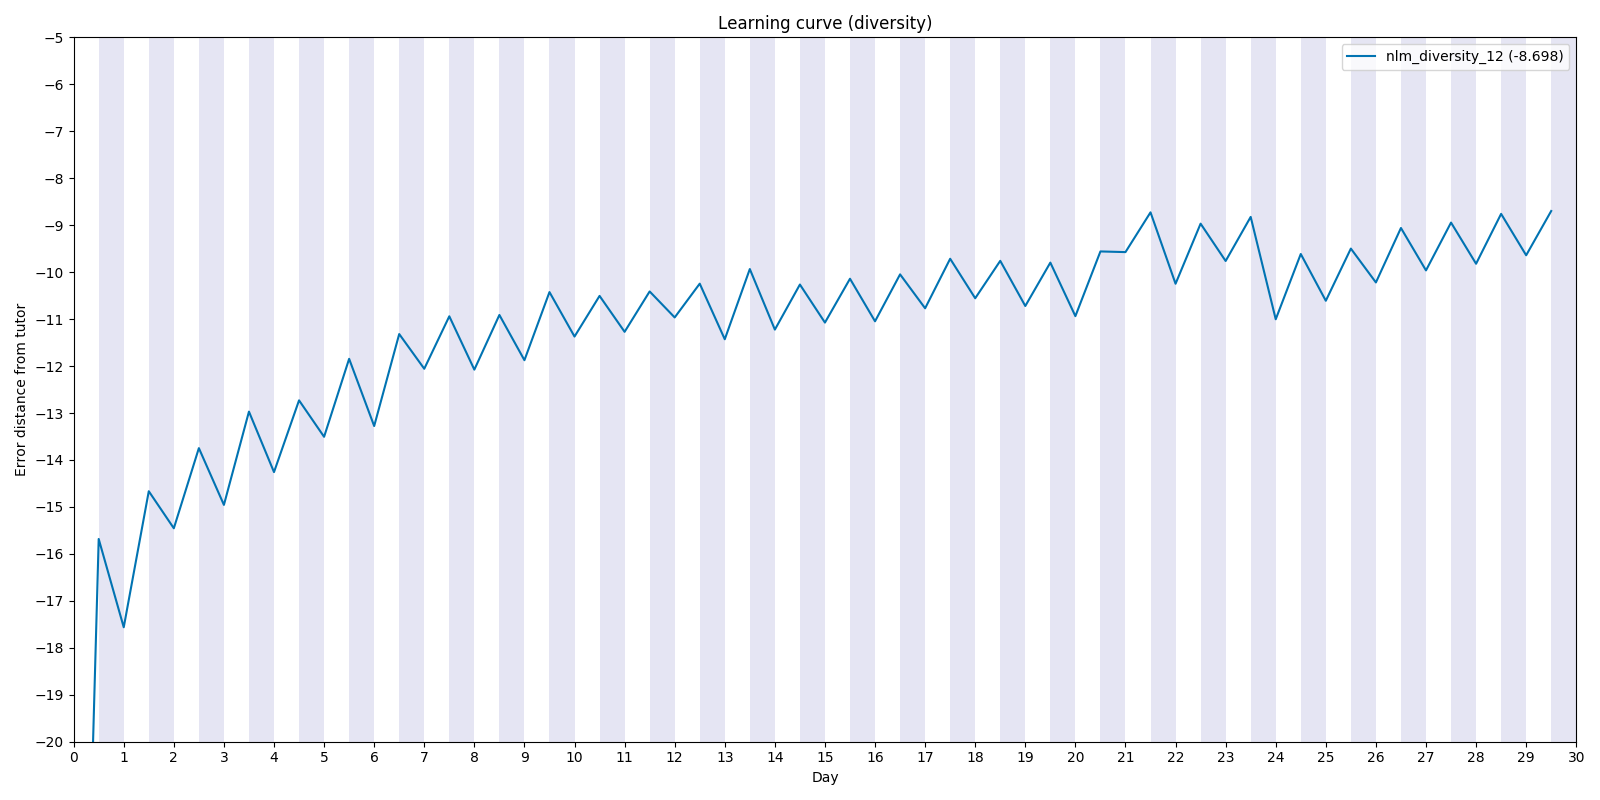

<IPython.core.display.Javascript object>


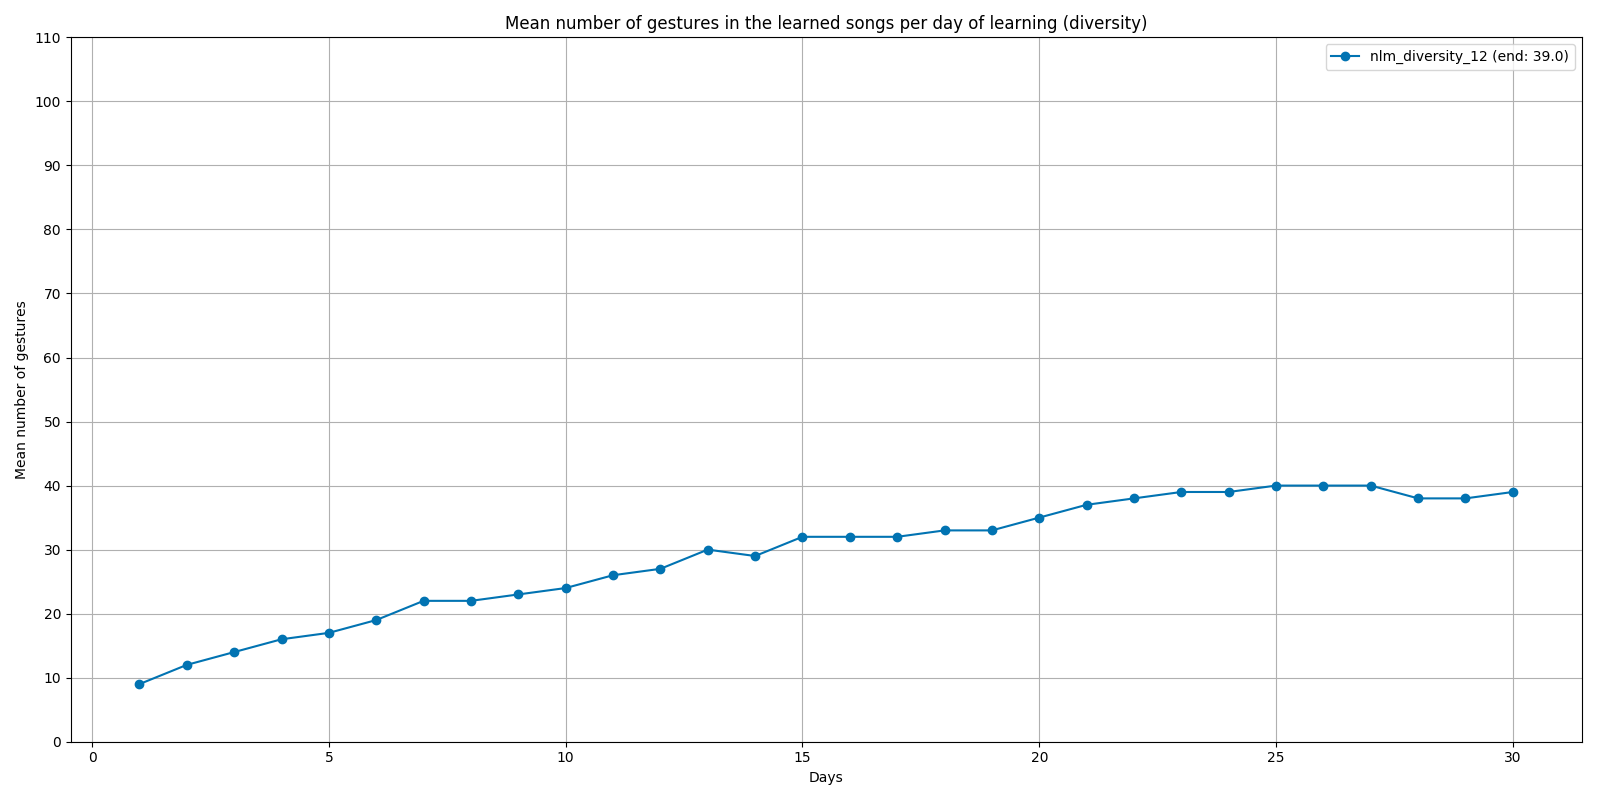

<IPython.core.display.Javascript object>


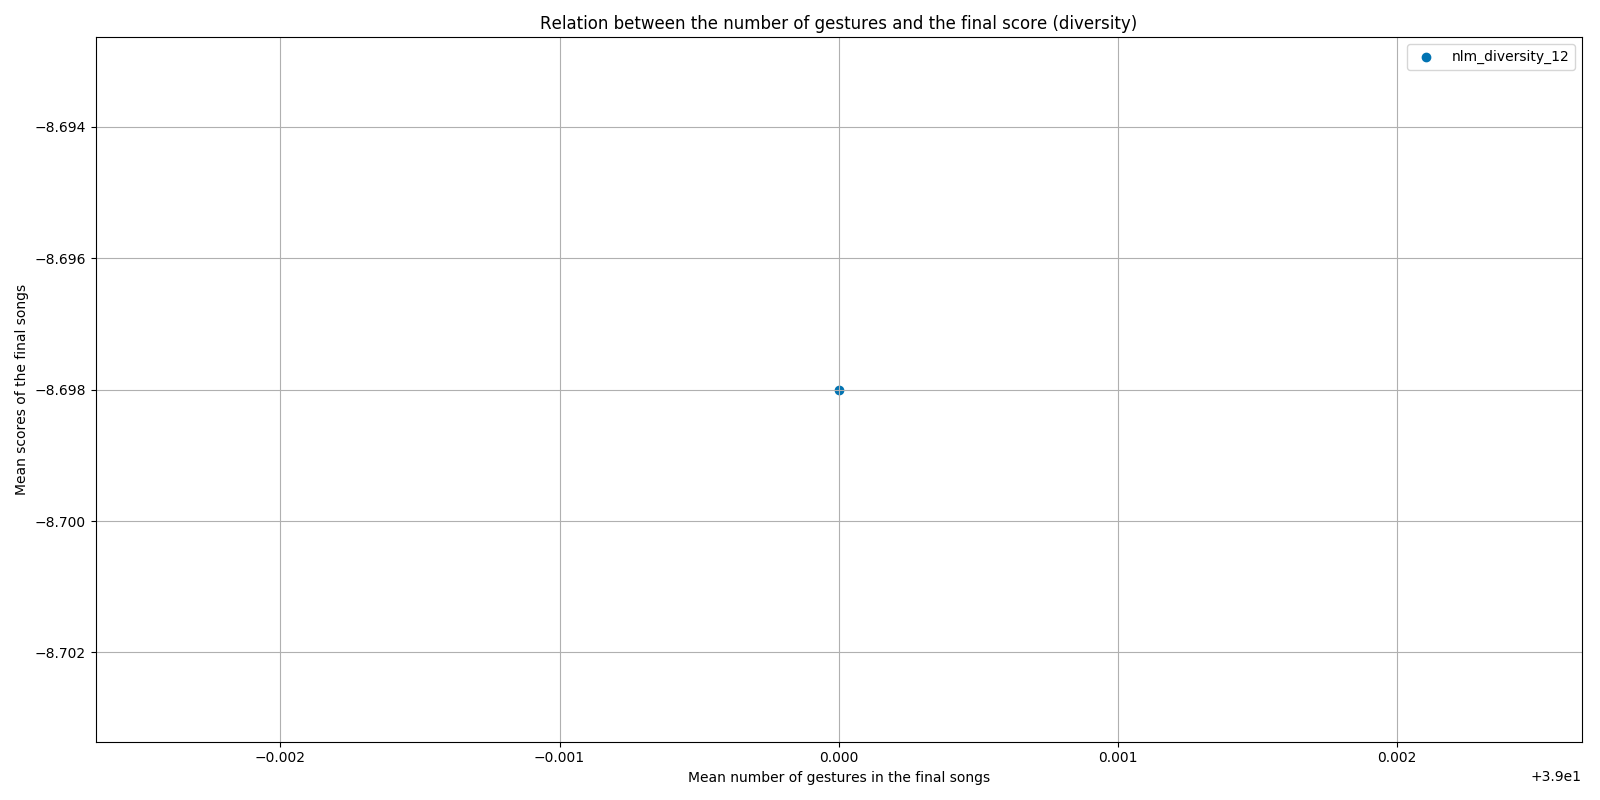

In [10]:
cluster_sim_path = res_path + 'nlm_diversity_12/'
param_filter = []
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
min_scores, final_scores, nb_gest, label_names = tup
title = "diversity"
plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps, title)
plot_mean_number_gestures(nb_gest, label_names, run_param['days'], title)

# Comparison between nlm_diversity_7_180903_151131 and nlm_diversity_9_180904_175752

Shared parameters:
- number of seeds: 10
- days: 60
- train_per_day: 200
- iter_per_train: 20
- night_concurrent: 10
- replay: 100
- dev

Differences:
- prior: cste_alpha: 0.2 and 2

seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['nlm_diversity_7']
number of simulations: 1
number of seeds per simulation: 10
seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['10_10_75_5_muta+nlm_diversity_9']
number of simulations: 1
number of seeds per simulation: 10


<IPython.core.display.Javascript object>


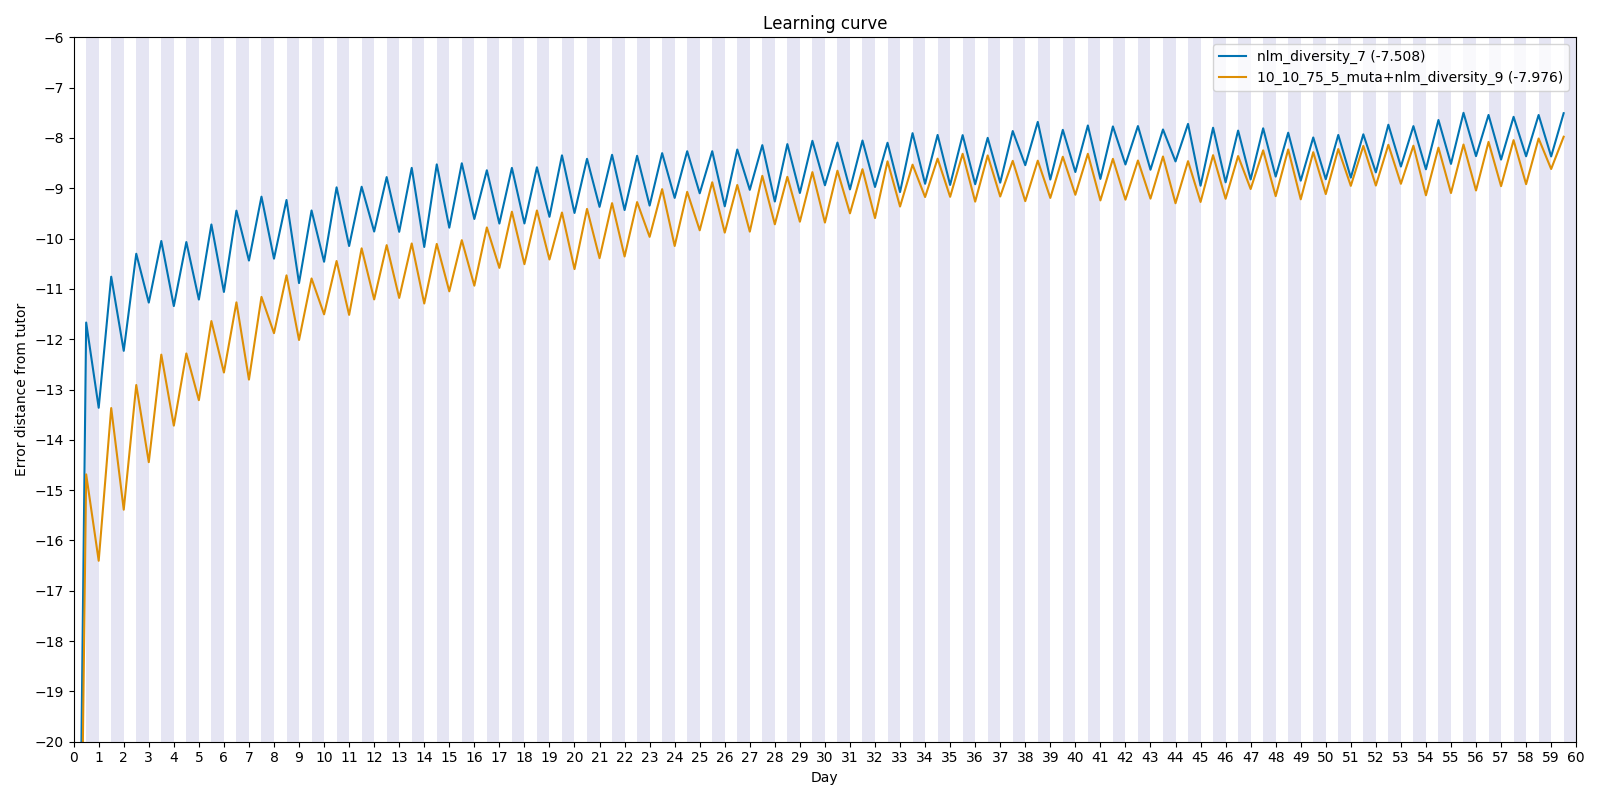

<IPython.core.display.Javascript object>


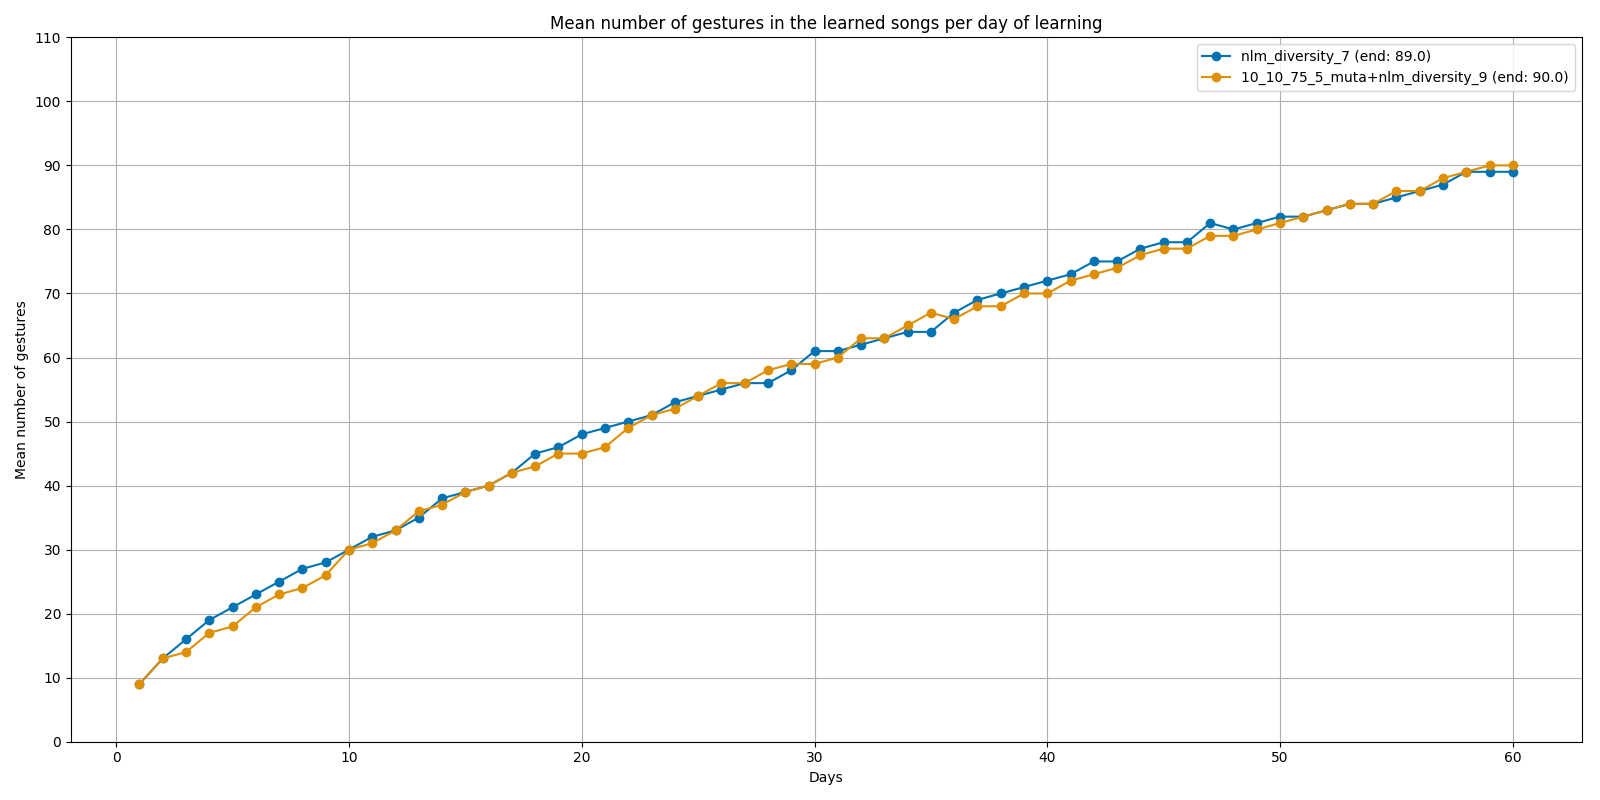

In [16]:
# -- Extract nlm_diversity_7 data - part 1 --
cluster_sim_path = res_path + 'nlm_diversity_7_180903_151131/'
param_filter = []
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# -- Extract nlm_diversity_7 data - part 2 --
tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
min_scores_7, final_scores_7, nb_gest_7, label_names_7 = tup

# Extract nlm_diversity_9 data --
cluster_sim_path = res_path + 'nlm_diversity_9_180904_175752/'
param_filter = [["10_10_75_5"]]
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)
tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
min_scores_9, final_scores_9, nb_gest_9, label_names_9 = tup

# -- Aggregation of the results --
min_scores = np.concatenate((min_scores_7, min_scores_9))
final_scores = np.concatenate((final_scores_7, final_scores_9))
nb_gest = np.concatenate((nb_gest_7, nb_gest_9))
label_names = label_names_7 + label_names_9

# -- Plot results --
plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps)
plot_mean_number_gestures(nb_gest, label_names, run_param['days'])

# nlm_diversity_7_180903_151131

New night learning algorithm (nlm): mutate_microbial_diversity_continuous_uniform
    - no more diversity_ threshold and counting the number of neighbours under this threshold

- Changes on prior and dev
- beta max = -0.002
    - /!\ Be careful of using the correct synh.py code which truncate beta correctly
- "night_concurrent": 10
- "replay": 100

seeds = ['seed0', 'seed1', 'seed10', 'seed11', 'seed12', 'seed13', 'seed14', 'seed15', 'seed16', 'seed17', 'seed18', 'seed19', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['nlm_diversity_7']
number of simulations: 1
number of seeds per simulation: 20


<IPython.core.display.Javascript object>


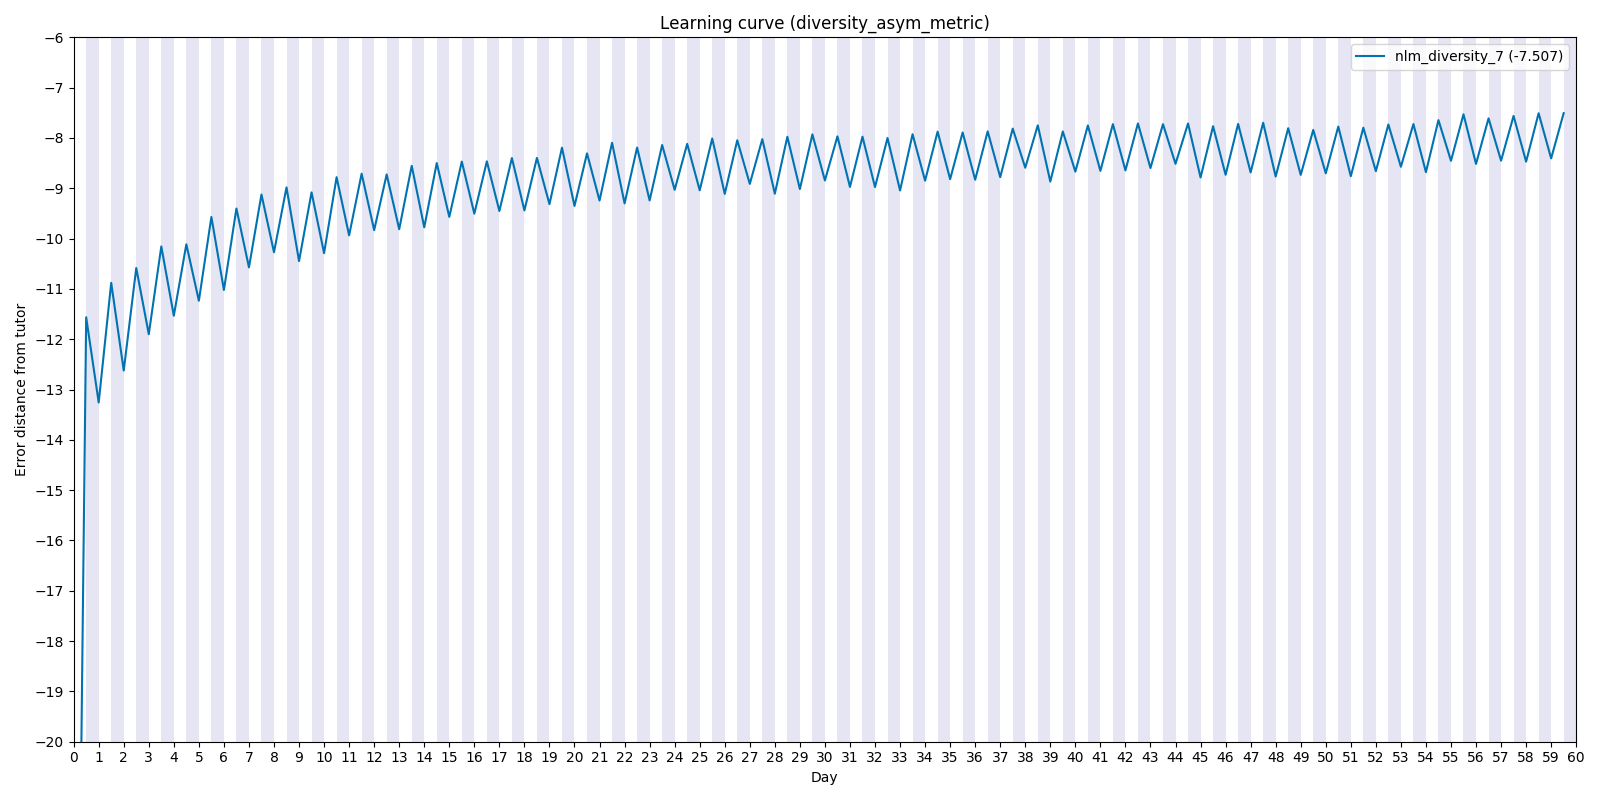

<IPython.core.display.Javascript object>


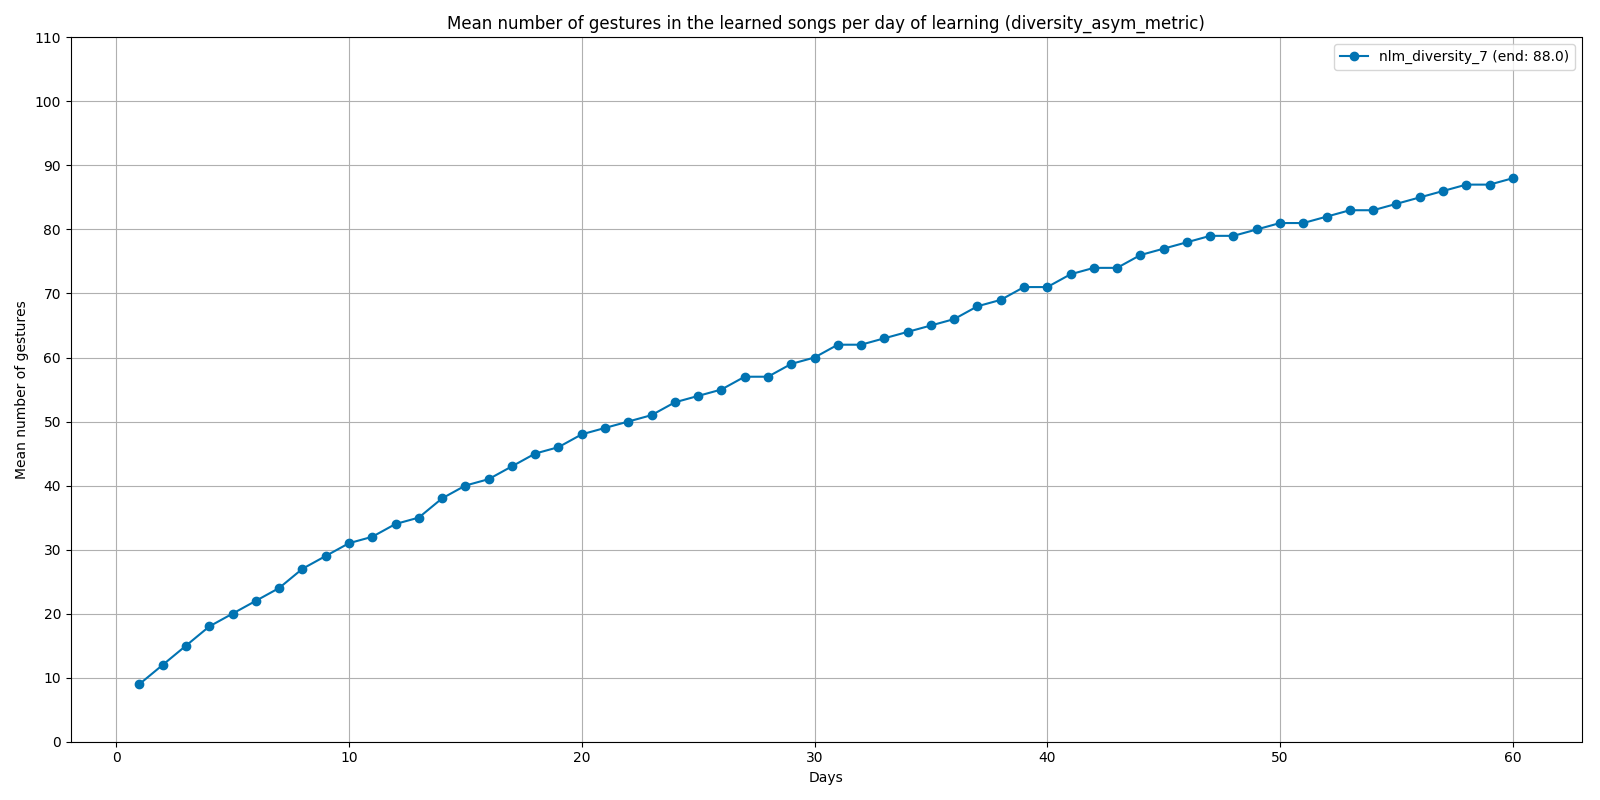

<IPython.core.display.Javascript object>


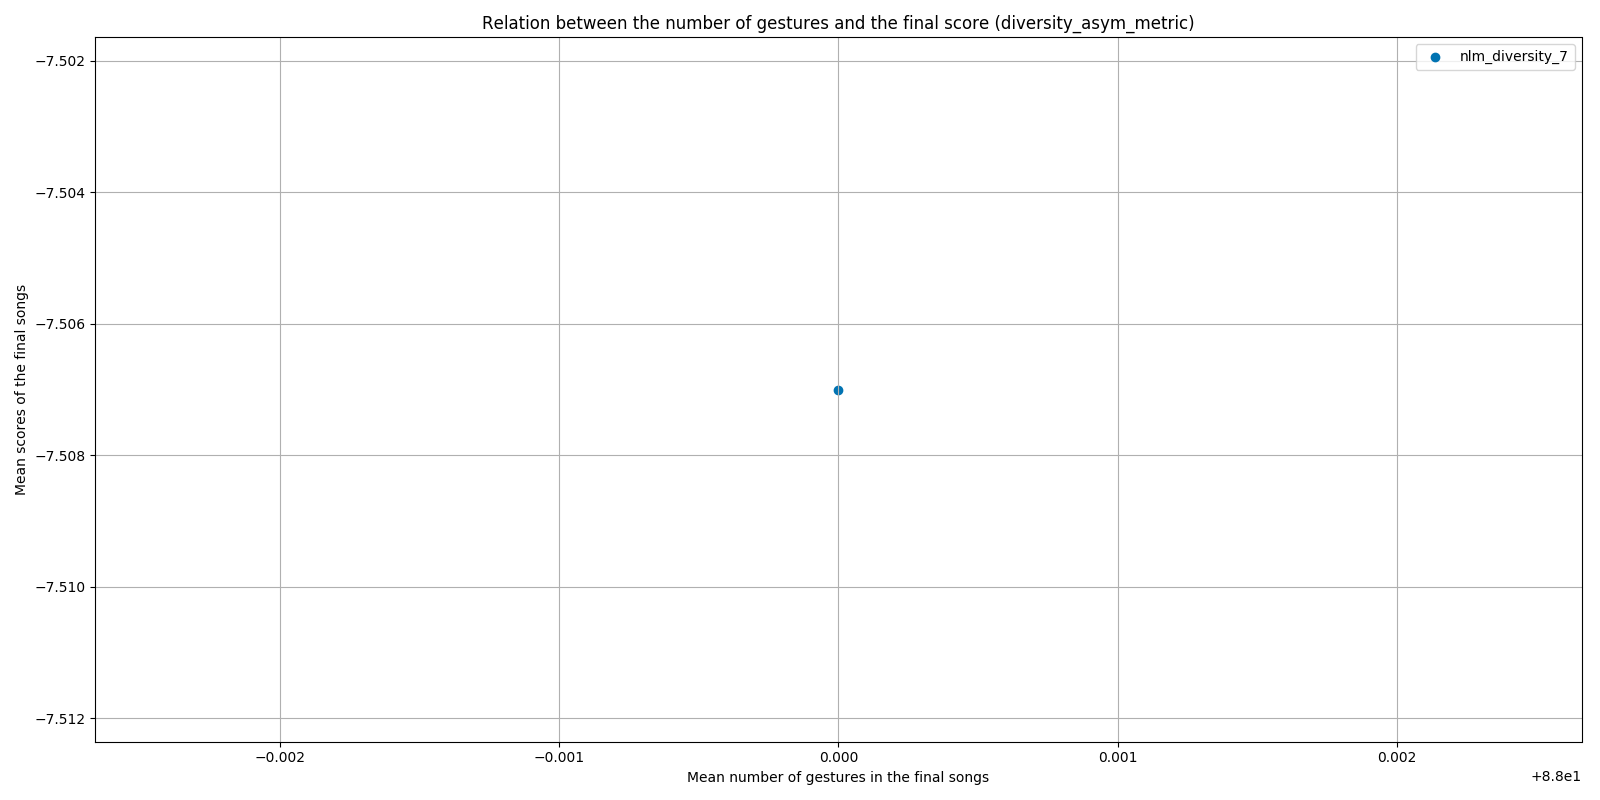

In [9]:
cluster_sim_path = res_path + 'nlm_diversity_7_180903_151131/'
param_filter = []
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
min_scores, final_scores, nb_gest, label_names = tup
title = "diversity_asym_metric"
plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps, title)
plot_mean_number_gestures(nb_gest, label_names, run_param['days'], title)
plot_corr_nb_gest_score(nb_gest, final_scores, label_names, title)

# long_grid_div_th_180821_183837

### longer simulation, with the new mutations and a different deviation

- 10 seeds
- 60 days
- div_th: 500, 1000, 1500, 2000, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4500, 5000, 5500, 6000
- different deviation
- Mutation probabilities:
	- P(delete) = 0.1
	- P(split) = 0.1
	- P(move) = 0.75
	- P(nothing) = 0.05
- day scores data available!

Lower div_th values

seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['long_grid_div_th+500_diversity_th', 'long_grid_div_th+1000_diversity_th', 'long_grid_div_th+1500_diversity_th', 'long_grid_div_th+2000_diversity_th', 'long_grid_div_th+2500_diversity_th', 'long_grid_div_th+2750_diversity_th']
number of simulations: 6
number of seeds per simulation: 10


<IPython.core.display.Javascript object>


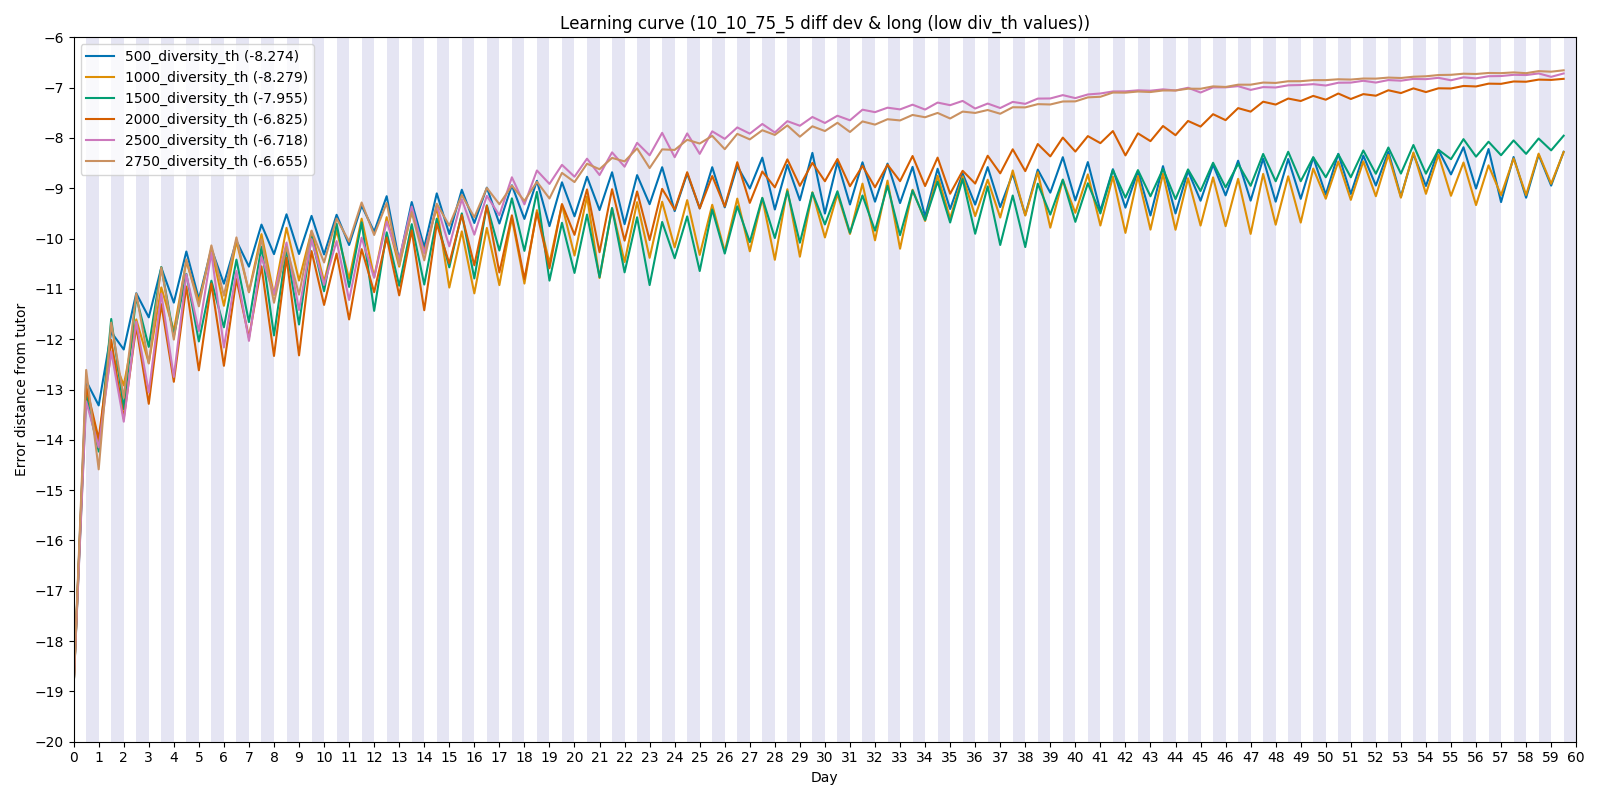

<IPython.core.display.Javascript object>


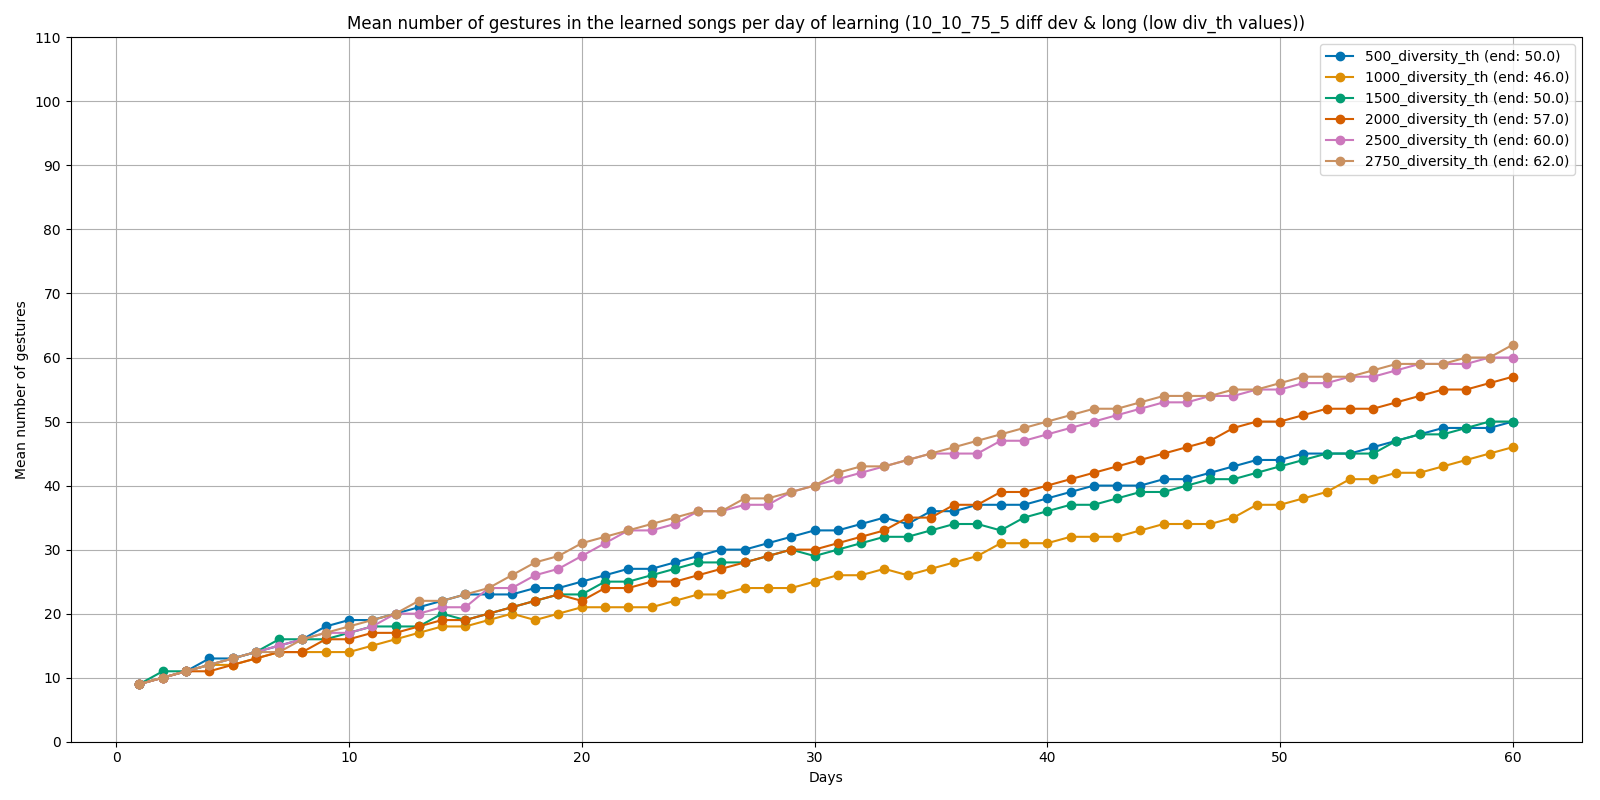

<IPython.core.display.Javascript object>


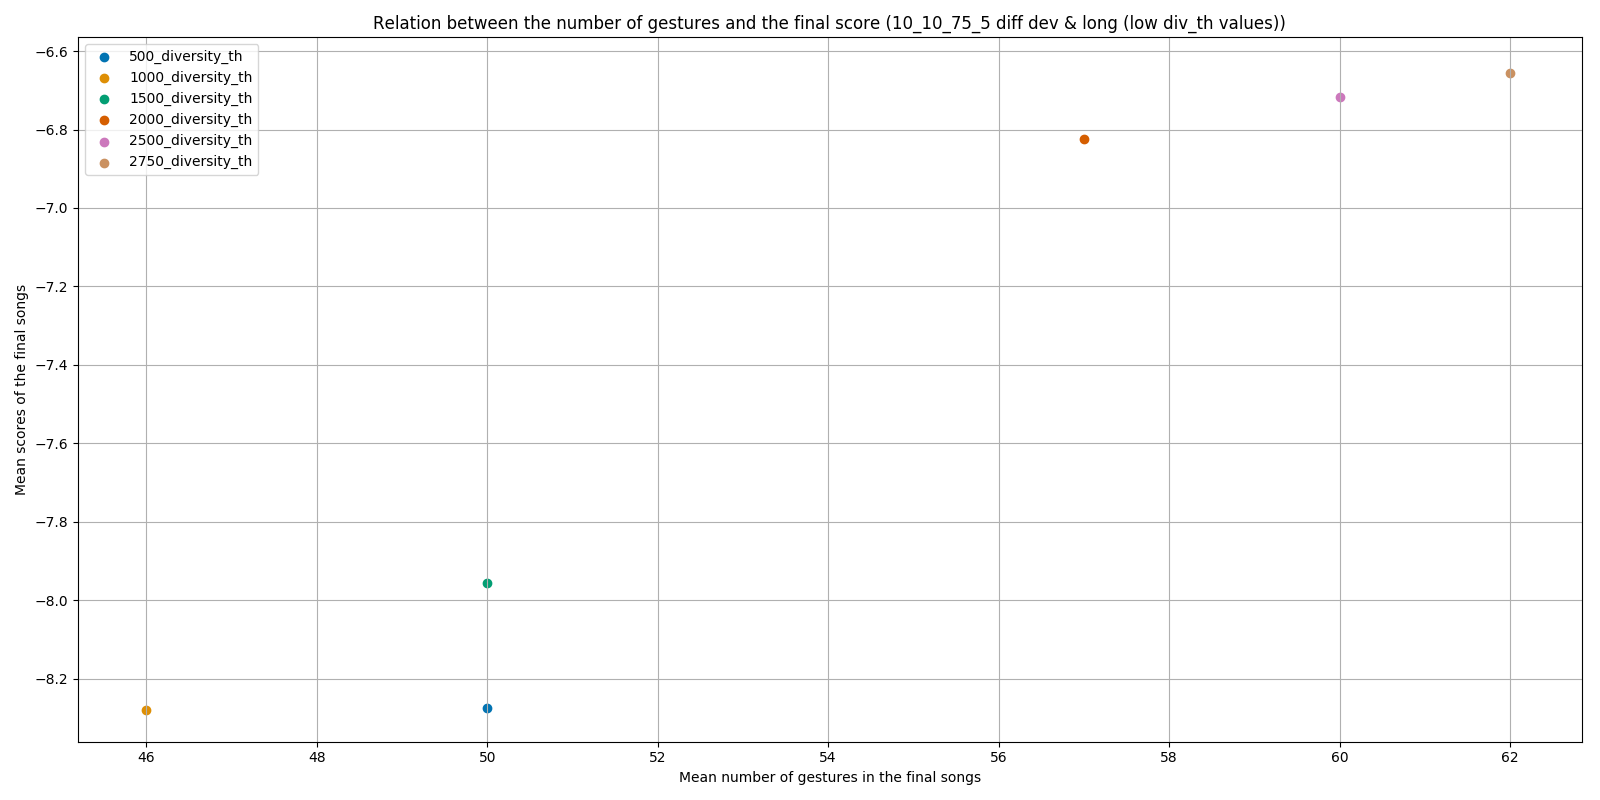

In [10]:
cluster_sim_path = res_path + 'long_grid_div_th_180821_183837/'
l_div_th = ['+500_', '1000', '1500', '2000', '2500',
            '2750']
param_filter = [l_div_th]
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
min_scores, final_scores, nb_gest, label_names = tup
title = "10_10_75_5 diff dev & long (low div_th values)"
plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps, title)
plot_mean_number_gestures(nb_gest, label_names, run_param['days'], title)
plot_corr_nb_gest_score(nb_gest, final_scores, label_names, title)

Higher div_th values

seeds = ['seed0', 'seed1', 'seed2', 'seed3', 'seed4', 'seed5', 'seed6', 'seed7', 'seed8', 'seed9']
sims = ['long_grid_div_th+2750_diversity_th', 'long_grid_div_th+3000_diversity_th', 'long_grid_div_th+3250_diversity_th', 'long_grid_div_th+3500_diversity_th', 'long_grid_div_th+3750_diversity_th', 'long_grid_div_th+4000_diversity_th', 'long_grid_div_th+4500_diversity_th', 'long_grid_div_th+5000_diversity_th', 'long_grid_div_th+5500_diversity_th', 'long_grid_div_th+6000_diversity_th']
number of simulations: 10
number of seeds per simulation: 10


<IPython.core.display.Javascript object>


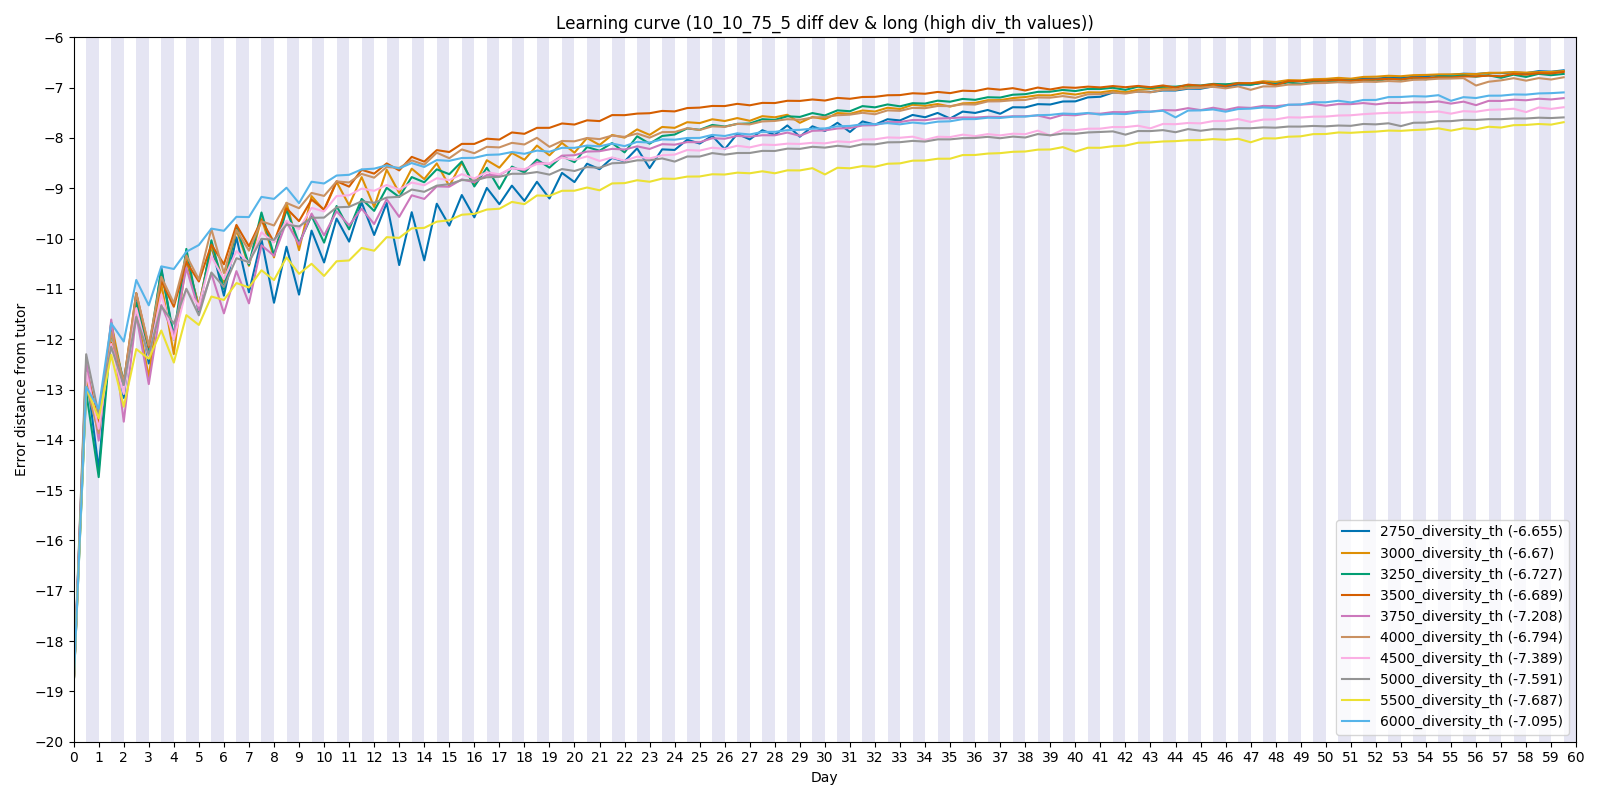

<IPython.core.display.Javascript object>


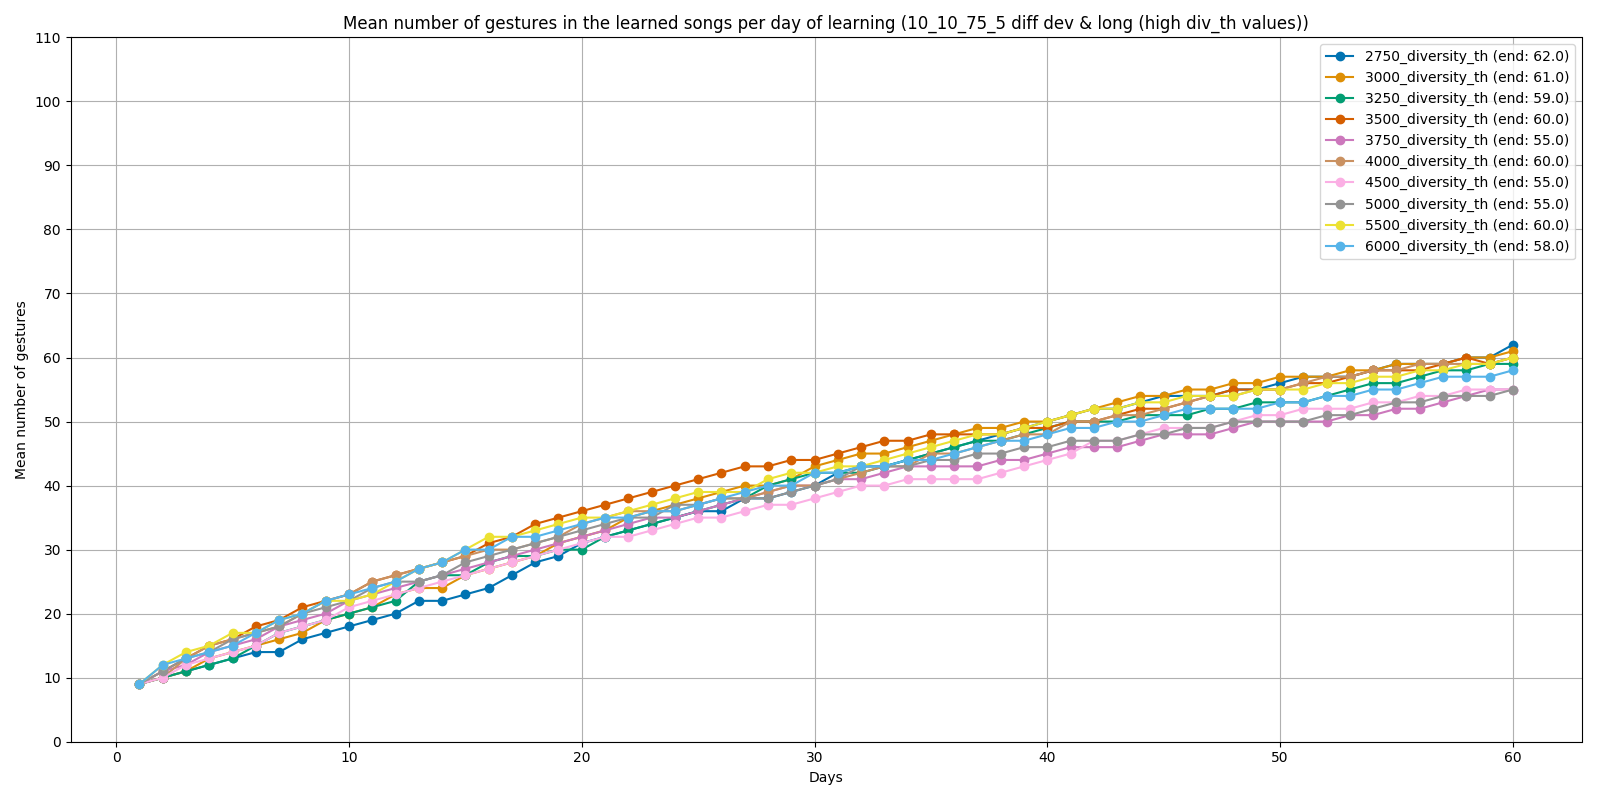

<IPython.core.display.Javascript object>


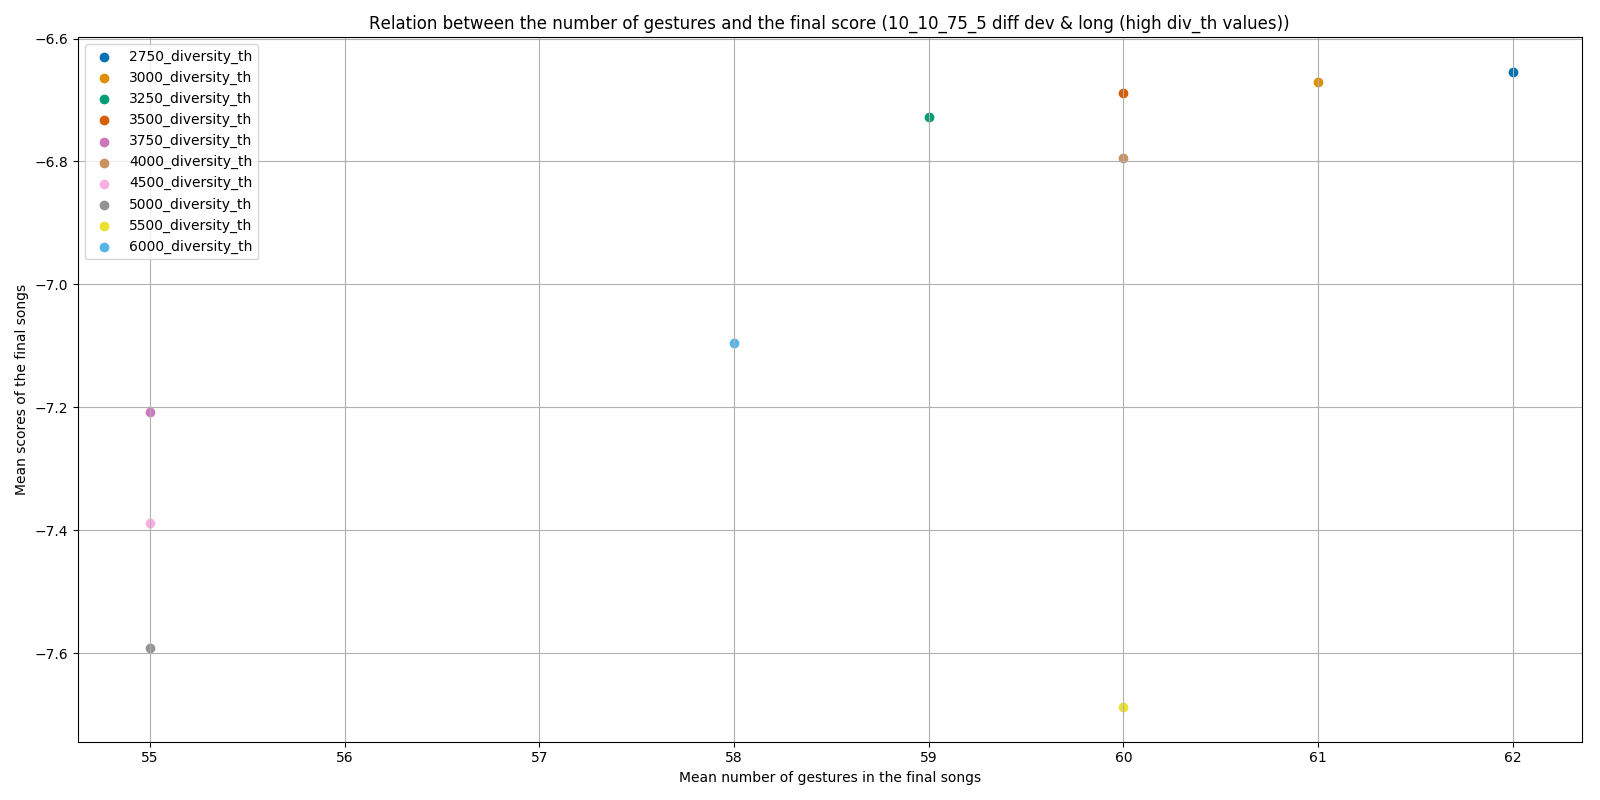

In [11]:
cluster_sim_path = res_path + 'long_grid_div_th_180821_183837/'
l_div_th = ['2750', '3000', '3250', '3500', '3750', 
            '4000', '4500', '5000', '5500', '6000']
param_filter = [l_div_th]
seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# -- Define the number of abscisse value --
sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
path = cluster_sim_path + sim_name
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
min_scores, final_scores, nb_gest, label_names = tup
title = "10_10_75_5 diff dev & long (high div_th values)"
plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps, title)
plot_mean_number_gestures(nb_gest, label_names, run_param['days'], title)
plot_corr_nb_gest_score(nb_gest, final_scores, label_names, title)

In [11]:
# # Specific index
# index_list = [i for i in [1,3]]
# index_list += [i for i in range(5, len(label_names))]
# print(index_list)
# specific_labels = [label_names[i] for i in index_list]
# title = "10_10_75_5 diff dev & long"
# print(min_scores[index_list,:].shape)
# print(final_scores.shape)
# plot_mean_learning_curve(min_scores[index_list,:], final_scores[index_list], specific_labels, nb_steps, title)

# long_grid_div_th_180816_120049

### longer simulation, with the new mutations and a different deviation

- 10 seeds
- 60 days
- div_th: 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
- different deviation
- Mutation probabilities:
	- P(delete) = 0.25
	- P(split) = 0.25
	- P(move) = 0.25
	- P(nothing) = 0.25

In [ ]:
# cluster_sim_path = res_path + 'long_grid_div_th_180816_120049/'
# param_filter = []
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# min_scores, final_scores, nb_gest, label_names = tup
# title = "25_25_25_25 new dev & long"
# plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps, title)
# plot_mean_number_gestures(nb_gest, label_names, run_param['days'], title)
# plot_corr_nb_gest_score(nb_gest, final_scores, label_names, title)

# grid_div_th_180813_213247 

### plus results from grid_div_th_180814_201731

- Possible div_th: 500, 1000, 1500, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4500, 5000, 5500, 6000
- P(delete) = 0.1
- P(split) = 0.1
- P(move) = 0.75
- P(nothing) = 0.05

In [1]:
# cluster_sim_path = res_path + 'grid_div_th_180813_213247/'
# l_div_th = ['2750', '3000', '3250', '3500', '3750', 
#             '4000', '4500', '5000', '5500', '6000']
# param_filter = [l_div_th]
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# min_scores, final_scores, nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# title = "10_10_75_5"
# plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps, title)
# plot_mean_number_gestures(nb_gest, label_names, run_param['days'], title)
# plot_corr_nb_gest_score(nb_gest, final_scores, label_names, title)

# grid_div_th_180803_023956

### Simulation testing different types of diversity_threshold, using the new types of mutation (delete, split, move, nothing)
- possible div_th: 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
- P(delete) = 0.25
- P(split) = 0.25
- P(move) = 0.25
- P(nothing) = 0.25

In [ ]:
# cluster_sim_path = res_path + 'grid_div_th_180803_023956/'
# param_filter = []
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# min_scores, final_scores, nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# title = ("25_25_25_25")
# plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps, title)
# plot_mean_number_gestures(nb_gest, label_names, run_param['days'], title)
# plot_corr_nb_gest_score(nb_gest, final_scores, label_names, title)

Rq : Les résultats semblent décorrelés, mais la range du nombre de geste est faible

# nlm_div_th_test_180713_173751

### Simulation testing different values of diversity_threshold

Aggregation of multiple simulations with a lot of different diversity_threshold values

In [ ]:
# """
# Possible diversity_threshold values:
# 100, 250, 500, 750, 
# 1000, 1250, 1500, 1750, 1875,
# 2000, 2250, 2500, 2750, 
# 3000, 3500, 4000, 5000
# """

# cluster_sim_path = res_path + 'nlm_div_th_test_180713_173751/'
# l_div_th = ['1500', '1750', '1875', '2000', '2250', '2500', '3000', '3500', '4000', '5000']
# # l_div_th = ['+500_', '1000', '2000', '3000', '4000', '5000']  #'+500_' and not '500' to avoid the 1500, 2500, etc... values
# param_filter = [['0p_1rms'],
#                 l_div_th]
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse values using data from 1 simulation --
# sim_name = '+'.join([seeds[0], sims[0]])
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # day morning and day evening

# min_scores, final_scores, nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# title = "previous mutation"
# plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps, title)
# plot_mean_number_gestures(nb_gest, label_names, run_param['days'], title)
# plot_corr_nb_gest_score(nb_gest, final_scores, label_names, title)

# Both dev_test simulations

- dev_test_180717_115457
- dev_test_180802_225322 (with new type of mutations)
    - P(delete) = 0.25
    - P(split) = 0.25
    - P(move) = 0.25
    - P(nothing) = 0.25

In [ ]:
# # old mutation version
# cluster_sim_path = res_path + 'dev_test_180717_115457/'
# param_filter = []
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# min_scores, final_scores, nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])

# # new mutation version
# cluster_sim_path = res_path + 'dev_test_180802_225322/'
# param_filter = []
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# tup = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# min_scores_muta, final_scores_muta, nb_gest_muta, label_names_muta = tup
# label_names_muta = [elt+"_muta" for elt in label_names_muta]

# min_scores = np.concatenate((min_scores, min_scores_muta))
# final_scores = np.concatenate((final_scores, final_scores_muta))
# nb_gest = np.concatenate((nb_gest, nb_gest_muta))
# label_names = label_names + label_names_muta
# plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps)
# plot_mean_number_gestures(nb_gest, label_names, run_param['days'])

# dev_test_180717_115457

### Simulation testing different kinds of dev parameters

In [ ]:
# cluster_sim_path = res_path + 'dev_test_180717_115457/'
# param_filter = []
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# min_scores, final_scores, nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps)
# plot_mean_number_gestures(nb_gest, label_names, run_param['days'])

# dev_test_180802_225322

### Simulation testing different kinds of deviation parameters, using the new types of mutation (delete, split, move, nothing)
- P(delete) = 0.25
- P(split) = 0.25
- P(move) = 0.25
- P(nothing) = 0.25

In [ ]:
# cluster_sim_path = res_path + 'dev_test_180802_225322/'
# param_filter = []
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# min_scores, final_scores, nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps)
# plot_mean_number_gestures(nb_gest, label_names, run_param['days'])

# dlm_nlm_equilibrium_180807_173045

### Simulation testing parameters linked with the day algorithm and the night algorithm
- Mutation probabilites:
    - P(delete) = 0.25
    - P(split) = 0.25
    - P(move) = 0.25
    - P(nothing) = 0.25
- Day:
    - train_per_day
    - iter_per_train
- Night:
    - night_concurrent
    - replay

In [ ]:
# cluster_sim_path = res_path + 'dlm_nlm_equilibrium_180807_173045/'
# param_filter = [['100_trainings'], ['20_iter'],['10_night_conc', '20_night_conc'],['100_replay', '200_replay']]
# seeds, sims = split_seeds_and_sims(cluster_sim_path, param_filter)

# # -- Define the number of abscisse value --
# sim_name = '+'.join([seeds[0], sims[0]])  # Use data from 1 simulation
# path = cluster_sim_path + sim_name
# with open(join(path, 'conf.json'), 'r') as f:
#     run_param = json.load(f)
# nb_steps = run_param['days'] * 2 # one "day" of simulation = 1 day and 1 night

# min_scores, final_scores, nb_gest, label_names = extract_data(cluster_sim_path, seeds, sims, run_param['days'])
# plot_mean_learning_curve(min_scores, final_scores, label_names, nb_steps)
# plot_mean_number_gestures(nb_gest, label_names, run_param['days'])
# plot_corr_nb_gest_score(nb_gest, final_scores, label_names)

# pitch_rms_test_180712_103336

(old simulation)

Test the utility of the pitch and / or the rms feature in the score calculation

In [ ]:
# cluster_sim_path = res_path + 'pitch_rms_test_180712_103336/'
# param_filter = [['mutate_microbial_diversity_uniform']]
# aggregated_results(cluster_sim_path, param_filter=param_filter)